In [1]:
import numpy as np

import matplotlib.pyplot as plt

import torch

import torch.nn as nn

In [17]:
from h3 import h3

In [11]:
import geojson

In [12]:
import pickle as pk

In [33]:
import folium

In [86]:
from branca.colormap import linear

In [2]:
data = np.load('./population_density.npy')

data = data.T.reshape(-1, 30, 24)

num_locations = data.shape[0]
num_time = data.shape[1]
num_days = data.shape[2]

K = 6
LAMBDA = 1e-4
MAXITER = 10

In [3]:
u = nn.Parameter(torch.rand([num_locations, K]))
v = nn.Parameter(torch.rand([num_time, K]))
w = nn.Parameter(torch.rand([num_days, K]))

In [4]:
data = torch.Tensor(data)

In [5]:
optimizer = torch.optim.RMSprop([u, v, w], lr=1e-3)

In [6]:
optimizer.zero_grad()

for i in range(10000):
    u_plus = nn.functional.softplus(u)
    v_plus = nn.functional.softplus(v)
    w_plus = nn.functional.softplus(w)
    loss = nn.functional.mse_loss(data, torch.einsum('uk,vk,wk->uvw', u_plus, v_plus, w_plus))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print('loss: {:.4f}'.format(loss.item()), end='\r')

In [7]:
u = nn.functional.softplus(u).detach().numpy()
v = nn.functional.softplus(v).detach().numpy()
w = nn.functional.softplus(w).detach().numpy()

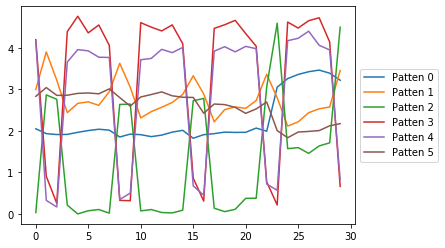

In [8]:
plt.plot(v)
plt.legend(['Patten ' + str(i) for i in range(K)], loc='center left', bbox_to_anchor=(1, 0.5))

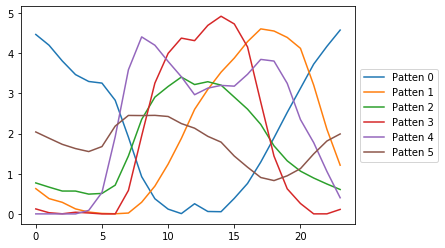

In [9]:
plt.plot(w)
plt.legend(['Patten ' + str(i) for i in range(K)], loc='center left', bbox_to_anchor=(1, 0.5))

In [13]:
with open('./loc_dict.pk', 'rb') as f:
    loc_dict = pk.load(f)

In [130]:
u_geojson = [
    geojson.Feature(
        geometry=geojson.Polygon([h3.h3_to_geo_boundary(h3hash, geo_json=True)]),
        id=h3hash,
        properties={'spectrum': u[idx].tolist(), 'index': idx}
    )
    for idx, h3hash in loc_dict.items()]

In [131]:
with open('u_geojson.json', 'w') as f:
    geojson.dump(geojson.FeatureCollection(u_geojson), f)